# Source detection with Gammapy

## Introduction

This notebook show how to do source detection with Gammapy.
using one of the methods available in [gammapy.detect](http://docs.gammapy.org/en/latest/detect/index.html).

We will do this:

* produce 2-dimensional test-statistics (TS) images using Fermi-LAT 2FHL high-energy Galactic plane survey dataset
* run a peak finder to make a source catalog
* do some simple measurements on each source
* compare to the 2FHL catalog

Note that what we do here is a quick-look analysis.
Producing a real source catalog for Fermi-LAT, [HGPS](https://www.mpi-hd.mpg.de/hfm/HESS/pages/home/som/2016/01/) or CTA is a more elaborate procedure.

We will work with the following functions and classes:

* [photutils](http://photutils.readthedocs.io/en/latest/) and specifically the [photutils.detection.find_peaks](http://photutils.readthedocs.io/en/latest/api/photutils.detection.find_peaks.html) function.
* [gammapy.image.SkyImage](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyImage.html)
* [gammapy.image.SkyImageList](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyImageList.html)
* [gammapy.detect.TSImageEstimator](http://docs.gammapy.org/en/latest/api/gammapy.detect.TSImageEstimator.html)

## Setup

As always, let's get started with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from astropy import units as u
from astropy.convolution import Gaussian2DKernel
from astropy.coordinates import SkyCoord

from photutils.detection import find_peaks

from gammapy.image import SkyImageList
from gammapy.detect import TSImageEstimator
from gammapy.catalog import source_catalogs

## Compute TS image

In [3]:
# Load data from files
images = SkyImageList.read('../datasets/fermi_survey/all.fits.gz')
images['COUNTS'].name = 'counts'
images['BACKGROUND'].name = 'background'
images['EXPOSURE'].name = 'exposure'

In [4]:
# Compute a source kernel (source template) in oversample mode,
# PSF is not taken into account
kernel = Gaussian2DKernel(2.5, mode='oversample')

# Compute a TS map. 'On' is the raw counts map, 'Background' is the background model,
# 'ExpGammaMap' denotes to the exposure map.
estimator = TSImageEstimator()
result = estimator.run(images, kernel)

print('TS map computation took {0:.2f} s'.format(result.meta['runtime']))

TS map computation took 8.97 s


## Plot images

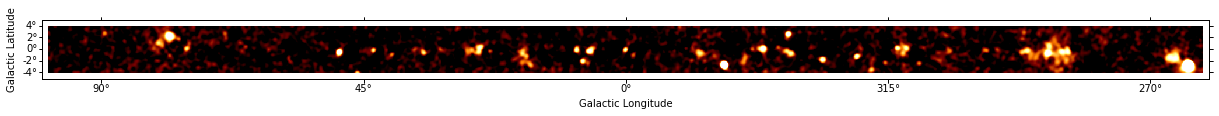

In [5]:
# Plot sqrt(TS) map
fig_ts = plt.figure(figsize=(18, 4))
ax_ts = fig_ts.add_axes([0.1, 0.1, 0.9, 0.9], projection=images['counts'].wcs)
ax_ts.imshow(result['sqrt_ts'], cmap='afmhot', origin='lower', vmin=0, vmax=10)
ax_ts.coords['glon'].set_axislabel('Galactic Longitude')
ax_ts.coords['glat'].set_axislabel('Galactic Latitude')

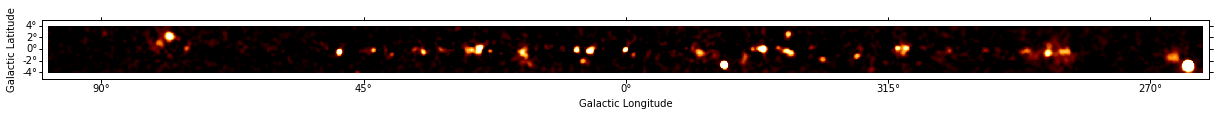

In [6]:
# Plot flux map (in units of m^-2 s^-1 TeV^-1)
fig_flux = plt.figure(figsize=(18, 4))
ax_flux = fig_flux.add_axes([0.1, 0.1, 0.9, 0.9], projection=images['counts'].wcs)
ax_flux.imshow(result['flux'], cmap='afmhot', origin='lower', vmin=0, vmax=1E-9)
ax_flux.coords['glon'].set_axislabel('Galactic Longitude')
ax_flux.coords['glat'].set_axislabel('Galactic Latitude')

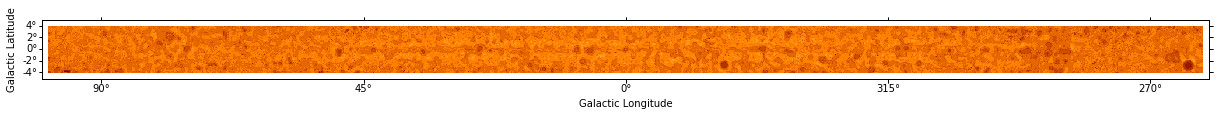

In [7]:
# Plot number of iterations of the fit per pixel
fig_iter = plt.figure(figsize=(18, 4))
ax_iter = fig_iter.add_axes([0.1, 0.1, 0.9, 0.9], projection=images['counts'].wcs)
ax_iter.imshow(result['niter'], cmap='afmhot', origin='lower', vmin=0, vmax=20)
ax_iter.coords['glon'].set_axislabel('Galactic Longitude')
ax_iter.coords['glat'].set_axislabel('Galactic Latitude')

## Source catalog

Let's run a peak finder on the `sqrt_ts` image to get a list of sources (positions and peak `sqrt_ts` values).

In [8]:
sources = find_peaks(
    data=result['sqrt_ts'].data,
    threshold=10,
    wcs=result['sqrt_ts'].wcs,
)
sources

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/photutils/detection/core.py:241: RuntimeWarning: invalid value encountered in greater
  peak_goodmask = np.logical_and(peak_goodmask, (data > threshold))


x_peak,y_peak,icrs_ra_peak,icrs_dec_peak,peak_value
,,deg,deg,
int64,int64,float64,float64,float64
1965,22,128.763048393,-45.2123926707,86.9619775881
1169,23,257.543796578,-44.4818050084,30.5466752124
1338,33,238.171431899,-56.1850306688,11.0775144301
1943,35,132.164175646,-46.1492131281,10.5063691882
1934,36,133.10541837,-46.7809911803,10.5550153527
1397,38,228.619705559,-59.1959453409,10.9478617214
1724,44,161.339190999,-59.7273459329,15.2158412054
509,46,290.82410573,14.1806184739,15.3210531504


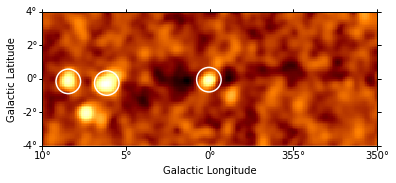

In [9]:
# Plot sources on top of significance sky image
result['sqrt_ts'].cutout(
    position=SkyCoord(0, 0, unit='deg', frame='galactic'),
    size=(8*u.deg, 20*u.deg)
).plot()

plt.gca().scatter(
    sources['icrs_ra_peak'], sources['icrs_dec_peak'],
    transform=plt.gca().get_transform('icrs'),
    color='none', edgecolor='white', marker='o', s=600, lw=1.5,
)

## Measurements

* TODO: show cutout for a few sources and some aperture photometry measurements (e.g. energy distribution, significance, flux)

In [10]:
# TODO

## Compare to 2FHL

TODO

In [11]:
fermi_2fhl = source_catalogs['2fhl']
fermi_2fhl.table[:5][['Source_Name', 'GLON', 'GLAT']]

Source_Name,GLON,GLAT
,deg,deg
str18,float32,float32
2FHL J0008.1+4709,115.339,-15.0688
2FHL J0009.3+5031,116.124,-11.7932
2FHL J0018.5+2947,114.463,-32.5424
2FHL J0022.0+0006,107.172,-61.8618
2FHL J0033.6-1921,94.28,-81.2224


## Exercises

TODO: put one or more exercises

In [12]:
# Start exercises here!

## What next?

In this notebook, we have seen how to work with images and compute TS images from counts data, if a background estimate is already available.

Here's some suggestions what to do next:

- TODO: point to background estimation examples
- TODO: point to other docs ...